## Лабораторная работа № 1 
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

### Часть 2

В данной части работы рассмотрены:
* разведочный анализ данных;
* работа с Dataframe API фреймворка `Apache Spark`.

Подключаем необходимые библиотеки.

In [61]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first, to_timestamp 
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [62]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [63]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [64]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

24/12/07 04:22:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Укажем базу данных, которая была создана в первой части лабораторной работы.

In [65]:
database_name = "Khripunov_database"

Установим созданную базу данных как текущую.

In [66]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем сохранённую в предыдущей части работы таблицу и загрузим её в `Spark Dataframe`.

In [67]:
df = spark.table("sobd_lab1_table2")

Выведем прочитанную таблицу на экран.

In [68]:
df.show()

+---------+---------+-------+---------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|Amount Received|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+---------------+-----------+----------------+--------------+-------------+
|     NULL|  0037220|0143318|       67597.03|   67597.03|            Yuan|   Credit Card|        false|
|     NULL|  0037220|0143318|      6639557.0|  6639557.0|            Yuan|           ACH|        false|
|     NULL|  0018184|0018184|          64.12|      64.12|            Yuan|  Reinvestment|        false|
|     NULL|  0117909|0040526|      2685393.2|  2685393.2|            Yuan|        Cheque|        false|
|     NULL|  0117909|0040526|      183521.27|  183521.27|            Yuan|   Credit Card|        false|
|     NULL|  0117909|0040526|      2184496.8|  2184496.8|            Yuan|           ACH|        false|
|     NULL|      012|0139273|        1080.59|    1080.59|       

Посмотрим на схему данных.

In [69]:
df.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Amount Received: float (nullable = true)
 |-- Amount Paid: float (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: boolean (nullable = true)



Вычислим количество строк в датафрейме.

In [70]:
df.count()

31898238

#### Анализ столбца `To Bank`

Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

Введем функцию, определяющую количество NULL-значений в столбце.

In [71]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце 'To Bank'.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений 'To Bank'.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце 'To Bank'
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце 'To Bank'
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [72]:
count_nulls(data=df, column_name="To Bank")

Число колонок с NULL: 0 (0.00%)


Столбец `To Bank` содержит 0 (0.00%) количество пропущенных значений. 


Отсортируем датафрейм по столбцу `To Bank`

In [73]:
df.orderBy("To Bank", ascending=False).show()

+---------+---------+-------+---------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|Amount Received|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+---------------+-----------+----------------+--------------+-------------+
|     NULL|   032405|    070|         543.56|     543.56|              US|          Cash|        false|
|     NULL|    03544|    070|         419.01|     419.01|              US|          Cash|        false|
|     NULL|  0369007|    070|        1298.44|    1298.44|            Yuan|          Cash|        false|
|     NULL|   031628|    070|         798.68|     798.68|              US|          Cash|        false|
|     NULL|  0330372|    070|         136.72|     136.72|            Euro|          Cash|        false|
|     NULL|   032276|    070|         252.22|     252.22|              US|          Cash|        false|
|     NULL| 03111496|    070|          57.63|      57.63|       

Проверим наличие дубликатов в датафрейме.

In [74]:
(
    df
    .groupBy("To Bank")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+-------+-----+
|To Bank|count|
+-------+-----+
|    027|84132|
|    012|74056|
|    000|61261|
|    020|58812|
|   0112|58720|
|    011|56368|
|    029|48049|
|   0114|47860|
|    004|47570|
|    025|42344|
|    006|40451|
|    003|38245|
|   0111|38167|
|   0113|37101|
|   0015|34517|
|  02310|33197|
|    026|32360|
|   0210|31862|
|    028|31687|
|  00214|30919|
+-------+-----+
only showing top 20 rows



In [75]:
df.filter(col("To Bank") == "000").show()

+---------+---------+-------+---------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|Amount Received|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+---------------+-----------+----------------+--------------+-------------+
|     NULL|      000|    000|         446.24|      66.63|              US|           ACH|        false|
|     NULL|      000|    000|         366.62|      54.74|              US|           ACH|        false|
|     NULL|   018824|    000|       14276.13|   14276.13|              US|           ACH|         true|
|     NULL|      000|    000|        4973.33|    4973.33|              US|  Reinvestment|        false|
|     NULL|      070|    000|         196.61|     196.61|              US|        Cheque|        false|
|     NULL|      070|    000|          71.94|      71.94|              US|   Credit Card|        false|
|     NULL|      070|    000|        5740.89|    5740.89|       

Реализация функции для расчета и визуализации распределения категориального признака

In [76]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Количество категорий признака To Bank: 62855


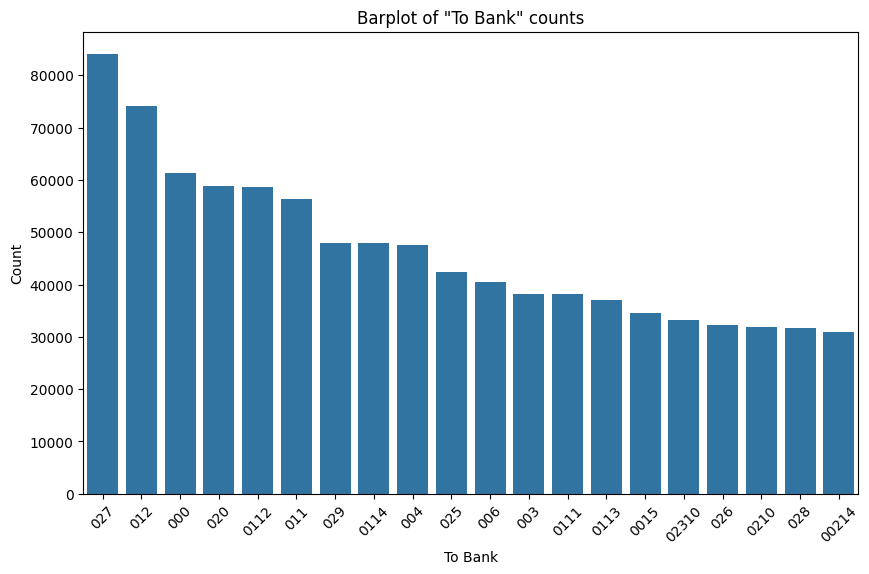

In [77]:
plot_cat_distribution(data=df, column_name="To Bank")

#### Анализ столбца `From Bank`

Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

Введем функцию, определяющую количество NULL-значений в столбце.

In [78]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [79]:
count_nulls(data=df, column_name="From Bank")

Число колонок с NULL: 0 (0.00%)


Столбец `From Bank` содержит 0 (0.00%) количество пропущенных значений. 

Проверим наличие дубликатов в датафрейме.

In [80]:
(
    df
    .groupBy("From Bank")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+---------+-------+
|From Bank|  count|
+---------+-------+
|      070|2960783|
|      012| 166485|
|      000| 159908|
|      020| 157093|
|      027| 149819|
|      011| 138033|
|     0112|  98772|
|      029|  91374|
|      025|  85366|
|      003|  84230|
|      004|  83707|
|     0114|  79976|
|      006|  75996|
|    00214|  75480|
|    02310|  75445|
|    01208|  74440|
|     0111|  71519|
|     0113|  70114|
|    02597|  67835|
|    00544|  62907|
+---------+-------+
only showing top 20 rows



In [81]:
df.filter(col("From Bank") == "070").show()

+---------+---------+-------+---------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|Amount Received|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+---------------+-----------+----------------+--------------+-------------+
|     NULL|      070|0115887|    1.5629031E7|1.5629031E7|            Yuan|        Cheque|        false|
|     NULL|      070|0034715|        1296.32|    1296.32|            Yuan|        Cheque|        false|
|     NULL|      070|0034715|          96.25|      96.25|            Yuan|   Credit Card|        false|
|     NULL|      070| 014902|         665.49|     665.49|            Yuan|        Cheque|        false|
|     NULL|      070| 014902|         272.18|     272.18|            Yuan|          Cash|        false|
|     NULL|      070|0237851|       15121.46|   15121.46|            Yuan|        Cheque|        false|
|     NULL|      070|0237303|          995.0|      995.0|       

Создадим функцию расчета и визуализации распределения категориальных признаков.

In [82]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Количество категорий признака From Bank: 122391


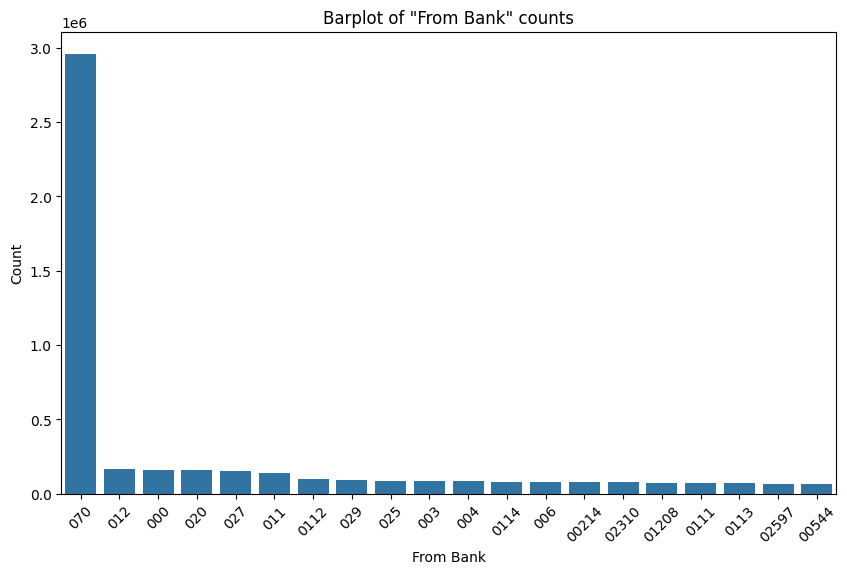

In [83]:
plot_cat_distribution(data=df, column_name="From Bank")

### На представленном графике видно, что столбец "From Bank" имеет сильную несбалансированность в распределении категорий:

1. Категория 070 доминирует, имея значительно большее количество записей (около 3 миллионов). Это явное преобладание говорит о том, что большая часть данных связана именно с этим значением.

2. Остальные категории содержат существенно меньше записей. Большинство других значений распределены равномерно, их частоты находятся на уровне намного ниже 500 тысяч.

#### Анализ столбца `Payment Currency`

Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

Введем функцию, определяющую количество NULL-значений в столбце.

In [84]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [85]:
count_nulls(data=df, column_name="Payment Currency")

Число колонок с NULL: 0 (0.00%)


Столбец `Payment Currency` содержит 0 (0.00%) количество пропущенных значений. 

Проверим наличие дубликатов в датафрейме.

In [86]:
(
    df
    .groupBy("Payment Currency")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+----------------+--------+
|Payment Currency|   count|
+----------------+--------+
|              US|11688249|
|            Euro| 7315958|
|            Yuan| 2330638|
|          Shekel| 1408707|
|        Canadian| 1078358|
|        UK Pound| 1018575|
|           Ruble|  975525|
|      Australian|  918569|
|             Yen|  856132|
|     Swiss Franc|  844623|
|    Mexican Peso|  841257|
|           Rupee|  738718|
|         Bitcoin|  688914|
|     Brazil Real|  629510|
|     Saudi Riyal|  564505|
+----------------+--------+



In [87]:
df.filter(col("Payment Currency") == "Shekel").show()

+---------+---------+--------+---------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank| To Bank|Amount Received|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+--------+---------------+-----------+----------------+--------------+-------------+
|     NULL|     0015|02181233|    1.1848133E7|1.1848133E7|          Shekel|        Cheque|        false|
|     NULL|     0220|    0220|      1737313.4|  1737313.4|          Shekel|  Reinvestment|        false|
|     NULL| 03183148|03183148|        8566.13|    8566.13|          Shekel|  Reinvestment|        false|
|     NULL| 00181638|02182618|      1394334.0|  1394334.0|          Shekel|           ACH|        false|
|     NULL| 00180537|00181251|      1060714.0|  1060714.0|          Shekel|        Cheque|        false|
|     NULL| 01182567|01180412|       315343.0|   315343.0|          Shekel|        Cheque|        false|
|     NULL| 00182530|02182159|        15651.0|    15651

Создадим функцию расчета и визуализации распределения категориальных признаков.

In [88]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Количество категорий признака Payment Currency: 15


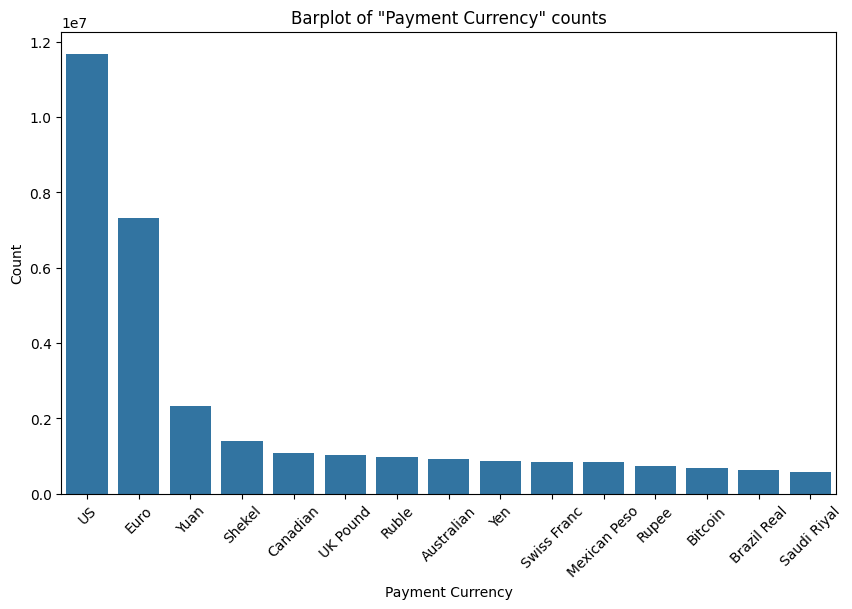

In [89]:
plot_cat_distribution(data=df, column_name="Payment Currency")

#### Анализ столбца `Payment Format`

Посмотрим внимательно на значения в столбце. Видно, что в данном столбце расположен **категориальный признак**.

Введем функцию, определяющую количество NULL-значений в столбце.

In [90]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [91]:
count_nulls(data=df, column_name="Payment Format")

Число колонок с NULL: 0 (0.00%)


Столбец `Payment Format` содержит 0 (0.00%) количество пропущенных значений. 

Проверим наличие дубликатов в датафрейме.

In [92]:
(
    df
    .groupBy("Payment Format")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+--------------+--------+
|Payment Format|   count|
+--------------+--------+
|        Cheque|12280058|
|   Credit Card| 8777816|
|           ACH| 3868410|
|          Cash| 3217531|
|  Reinvestment| 1945611|
|          Wire| 1119774|
|       Bitcoin|  689038|
+--------------+--------+



In [93]:
df.filter(col("Payment Format") == "ACH").show()

+---------+---------+-------+---------------+------------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|Amount Received| Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+---------------+------------+----------------+--------------+-------------+
|     NULL|  0037220|0143318|      6639557.0|   6639557.0|            Yuan|           ACH|        false|
|     NULL|  0117909|0040526|      2184496.8|   2184496.8|            Yuan|           ACH|        false|
|     NULL|      012|0139273|         665.57|      665.57|            Yuan|           ACH|        false|
|     NULL|  0237303|0034338|         357.61|      357.61|            Yuan|           ACH|        false|
|     NULL|      012|0143446|        6209.13|     6209.13|            Yuan|           ACH|        false|
|     NULL|  0234525|0142675|      5234402.5|   5234402.5|            Yuan|           ACH|        false|
|     NULL|  0237666|0034627|        2058.53|     2058.

Создадим функцию расчета и визуализации распределения категориальных признаков.

In [94]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Количество категорий признака Payment Format: 7


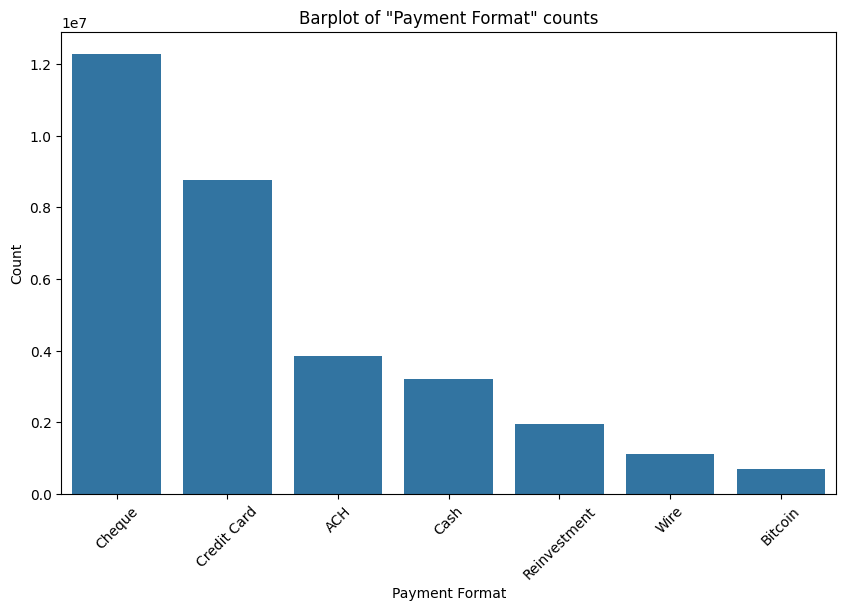

In [95]:
plot_cat_distribution(data=df, column_name="Payment Format")

#### Анализ столбца `Amount Received`

В соответствии с описанием и содержанием датасета логично считать данный признак **количественным**. Проверим его на наличие пропущенных значений.

In [96]:
count_nulls(data=df, column_name="Amount Received")

Число колонок с NULL: 0 (0.00%)


Видно, что пропуски в данном столбце отсутствуют.

Создадим функцию, позволяющую рассчитывать статистические показатели данных в столбцах и строить диаграмму "ящик с усами" для оценки наличия выбросов.

In [97]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          0.00
Среднее значение:              6431116.00
Среднеквадратичное отклонение: 2592744189.40
Первый квартиль:               201.97
Медиана:                       1439.92
Третий квартиль:               11480.81
Максимальное значение:         8158609145856.00


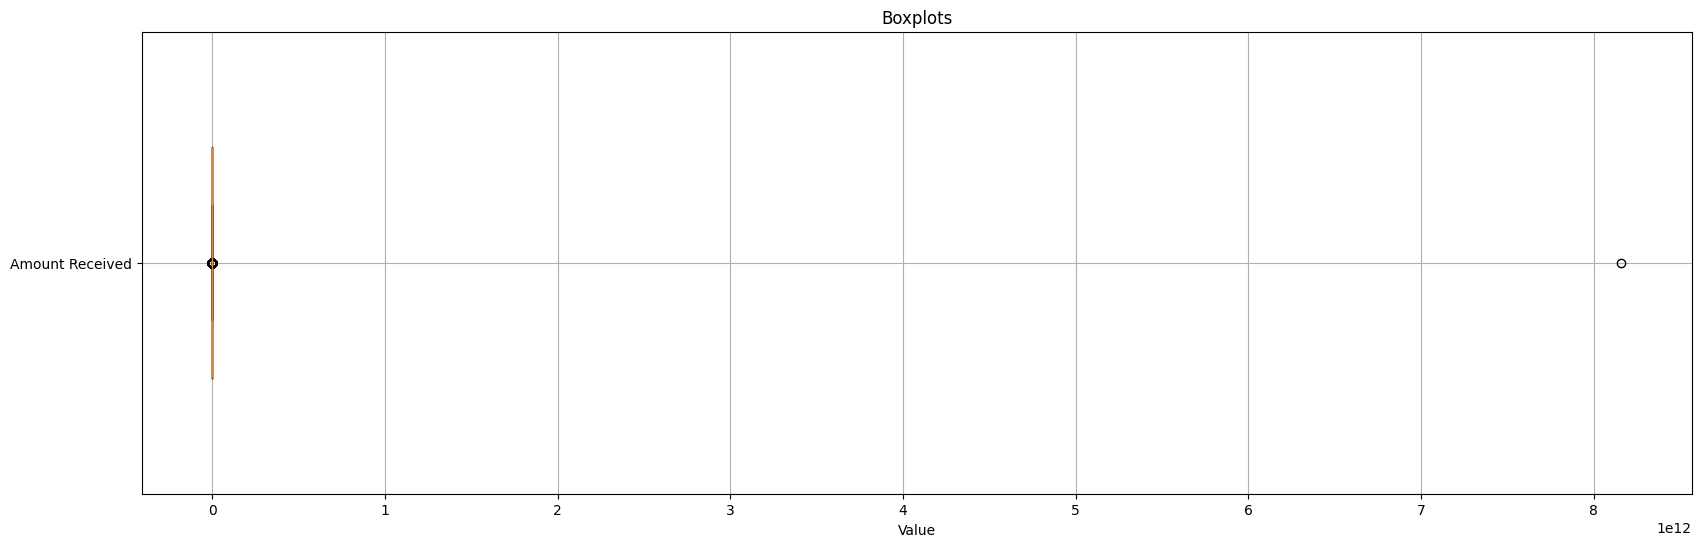

In [98]:
plot_boxplots(data=df, columns=["Amount Received"])

Распределение данных:
1. Минимальное значение: 0.00
2. Первый квартиль: 201.97 — это значение, ниже которого находится 25% данных.
3. Медиана: 1439.92 — значение, делящее данные пополам.
4. Третий квартиль: 11480.81 — значение, выше которого находится 25% данных.
5. Максимальное значение: 8,158,609,145,856.00 — экстремально большое значение.
6. Среднее значение: 6,431,116.00 — значительно больше медианы, что говорит о сильной положительной асимметрии (влияние выбросов).
7. Стандартное отклонение: 2,592,744,189.40 — очень большое значение, указывающее на высокую дисперсию в данных.

Итог:
В выборке присутствуют очень большие выбросы

Для более тщательного исследования создадим функцию для визуализации распределения категориального признака.

In [99]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

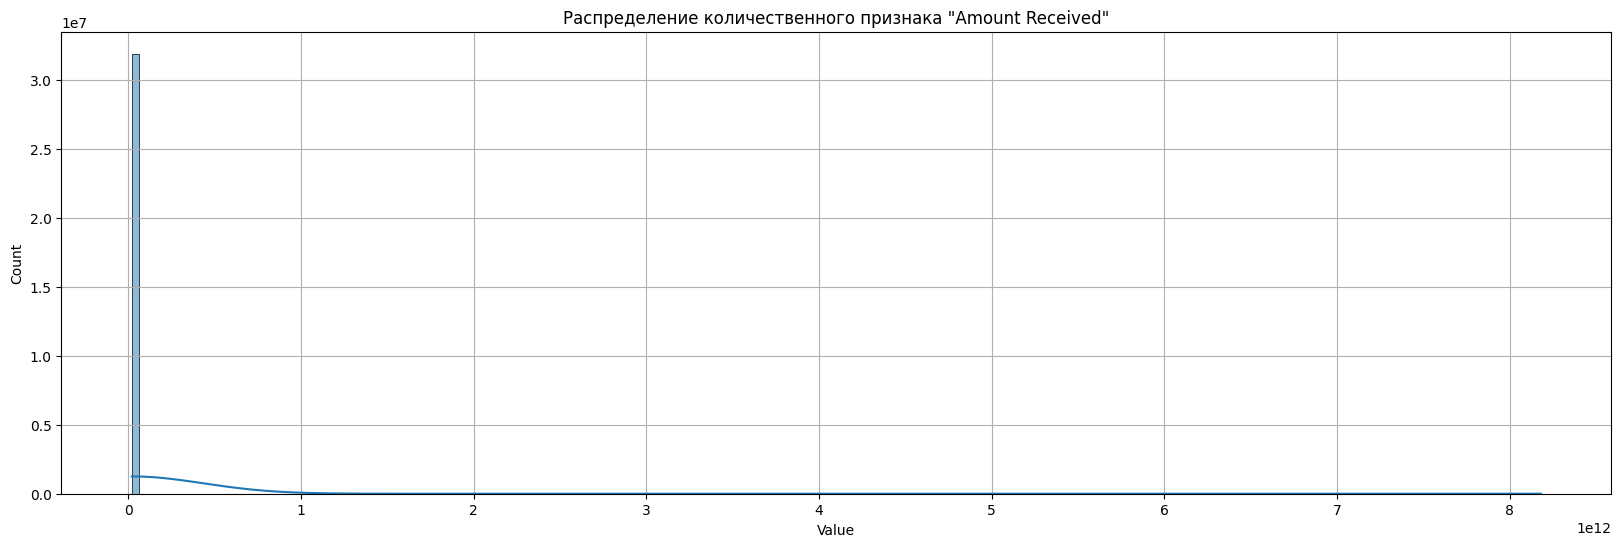

In [100]:
plot_quant_distribution(data=df, column="Amount Received")

Видно, что почти все данные не превышают значения 500, но при этом наблюдается малое количество довольно сильных выбросов. Обрежем эти выбросы, установив для них максимальную границу.

In [101]:
df = df.withColumn(
    "Amount Received",
    when(col("Amount Received") > 1000000.0, 1000000.0)
        .otherwise(col("Amount Received"))
)

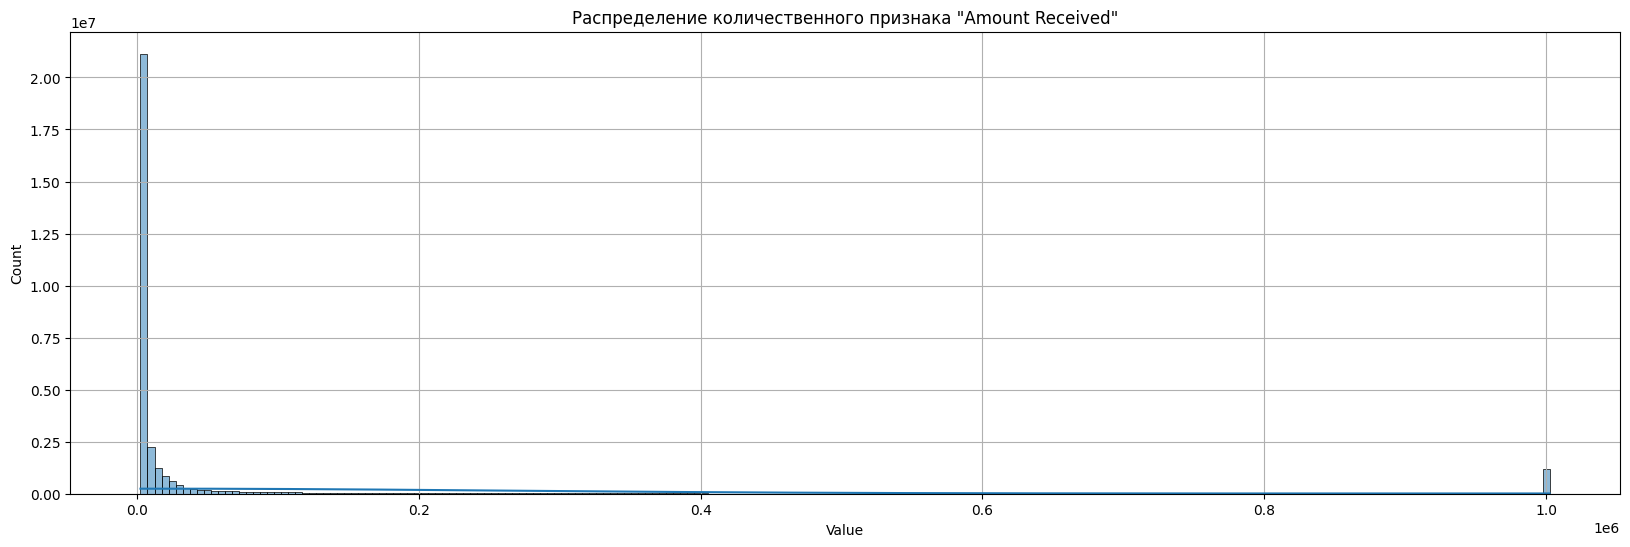

In [102]:
plot_quant_distribution(data=df, column="Amount Received")

Теперь диаграмма более эффективно представляет данные в столбце.

In [103]:
df.show()

+---------+---------+-------+------------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|   Amount Received|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+------------------+-----------+----------------+--------------+-------------+
|     NULL|  0037220|0143318|       67597.03125|   67597.03|            Yuan|   Credit Card|        false|
|     NULL|  0037220|0143318|         1000000.0|  6639557.0|            Yuan|           ACH|        false|
|     NULL|  0018184|0018184| 64.12000274658203|      64.12|            Yuan|  Reinvestment|        false|
|     NULL|  0117909|0040526|         1000000.0|  2685393.2|            Yuan|        Cheque|        false|
|     NULL|  0117909|0040526|     183521.265625|  183521.27|            Yuan|   Credit Card|        false|
|     NULL|  0117909|0040526|         1000000.0|  2184496.8|            Yuan|           ACH|        false|
|     NULL|      012|0139273|1080.589

#### Анализ столбца `Timestamp`

Введем функцию, определяющую количество NULL-значений в столбце.

In [130]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [131]:
count_nulls(data=df, column_name="Timestamp")

Число колонок с NULL: 31898238 (100.00%)


In [123]:
df = df.fillna({"Timestamp": "Unknown"})
count_nulls(data=df, column_name="Timestamp")

Число колонок с NULL: 31898238 (100.00%)


In [124]:
# Вывод схемы DataFrame
df.printSchema()


root
 |-- Timestamp: timestamp (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Amount Received: double (nullable = true)
 |-- Amount Paid: float (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: boolean (nullable = true)



#### Анализ столбца `Amount Paid`

В соответствии с описанием и содержанием датасета логично считать данный признак **количественным**. Проверим его на наличие пропущенных значений.

In [132]:
count_nulls(data=df, column_name="Amount Paid")

Число колонок с NULL: 0 (0.00%)


Видно, что пропуски в данном столбце отсутствуют.

Создадим функцию, позволяющую рассчитывать статистические показатели данных в столбцах и строить диаграмму "ящик с усами" для оценки наличия выбросов.

In [133]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          0.00
Среднее значение:              4417550.92
Среднеквадратичное отклонение: 1848313452.76
Первый квартиль:               203.30
Медиана:                       1440.48
Третий квартиль:               11328.19
Максимальное значение:         8158609145856.00


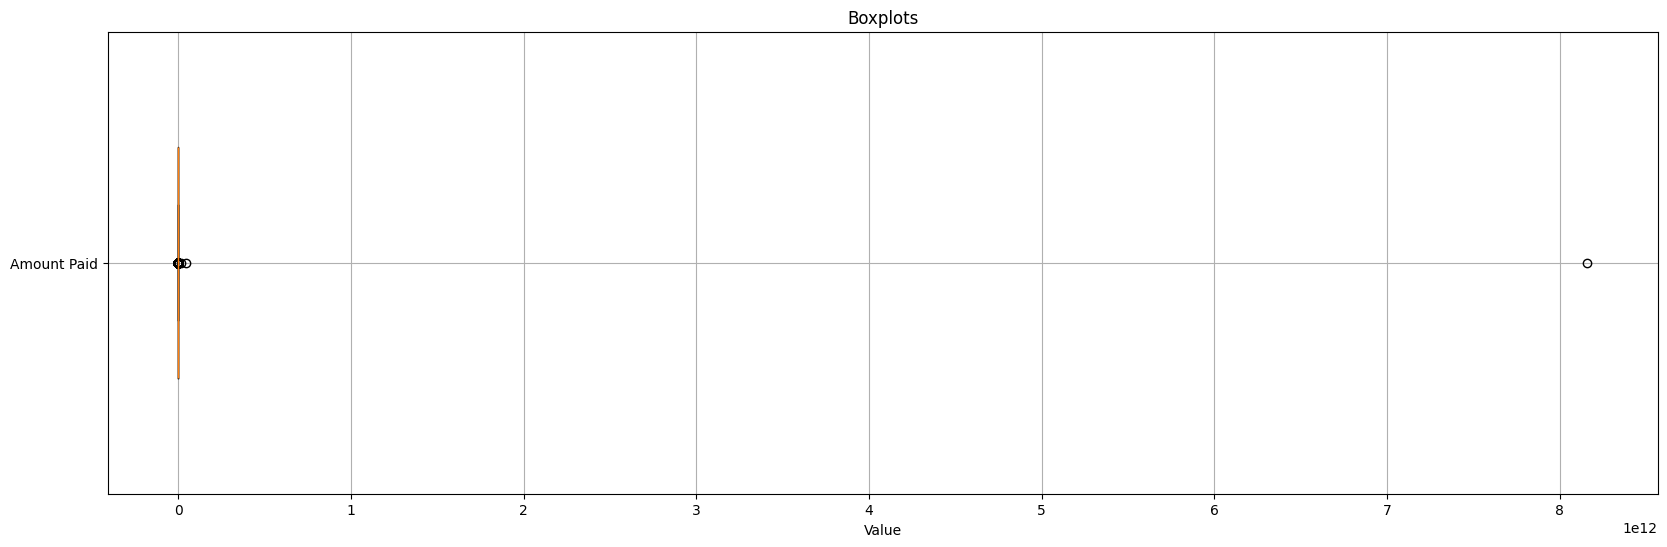

In [134]:
plot_boxplots(data=df, columns=["Amount Paid"])

Распределение данных:
1. Минимальное значение: 0.00
2. Первый квартиль: 203.30 — это значение, ниже которого находится 25% данных.
3. Медиана: 1440.48 — значение, делящее данные пополам.
4. Третий квартиль: 11328.19 — значение, выше которого находится 25% данных.
5. Максимальное значение: 8158609145856.00 — экстремально большое значение.
6. Среднее значение: 6,431,116.00 — значительно больше медианы, что говорит о сильной положительной асимметрии (влияние выбросов).
7. Стандартное отклонение: 2,592,744,189.40 — очень большое значение, указывающее на высокую дисперсию в данных.

Итог:
В выборке присутствуют очень большие выбросы

Для более тщательного исследования создадим функцию для визуализации распределения категориального признака.

In [135]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

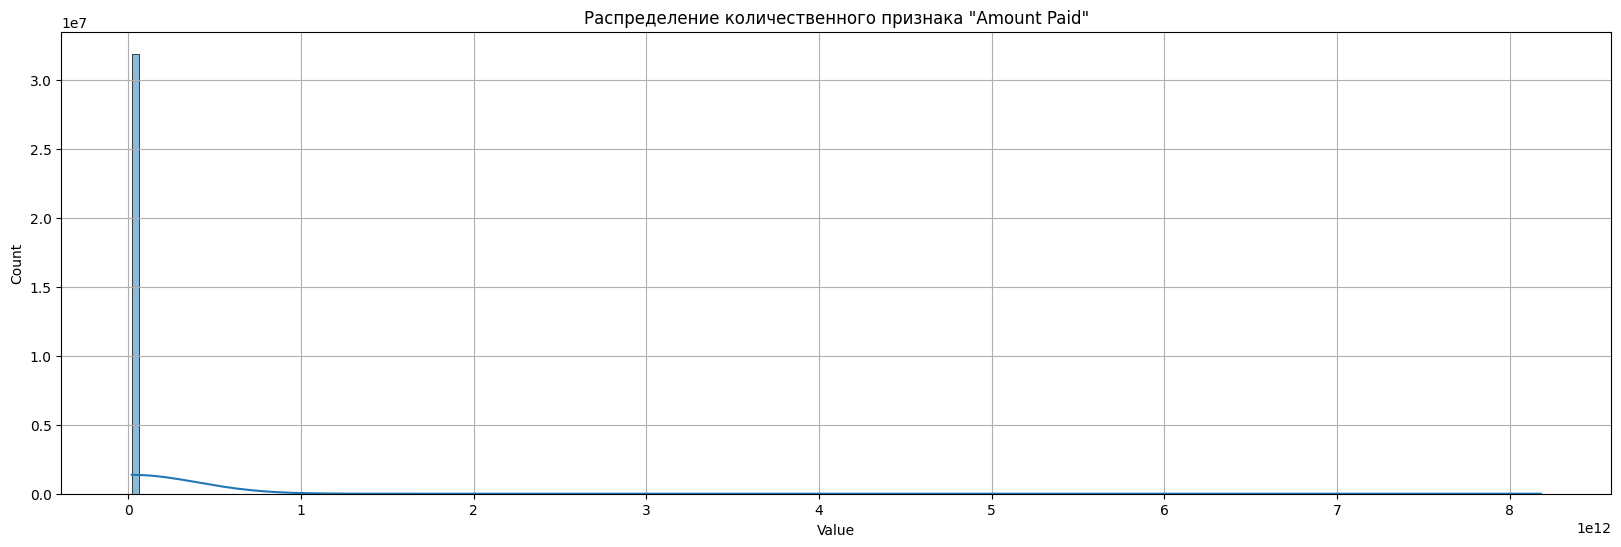

In [136]:
plot_quant_distribution(data=df, column="Amount Paid")

In [137]:
df = df.withColumn(
    "Amount Paid",
    when(col("Amount Paid") > 1000000.0, 1000000.0)
        .otherwise(col("Amount Paid"))
)

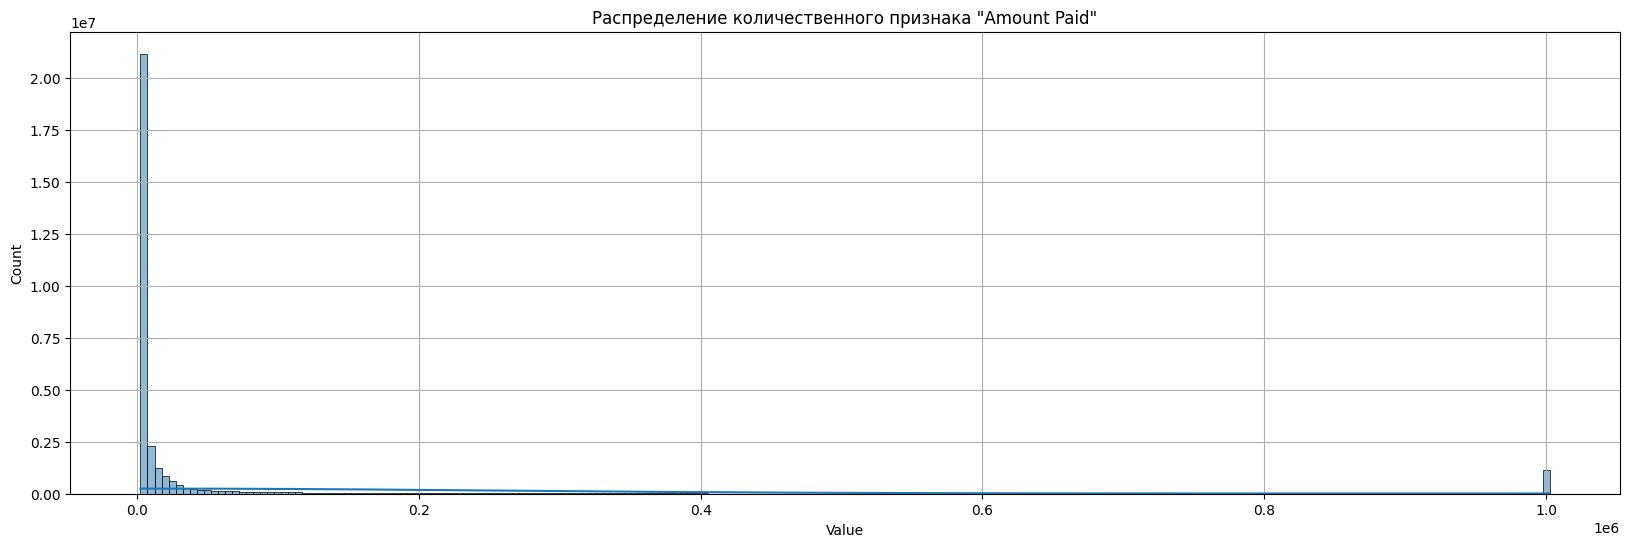

In [138]:
plot_quant_distribution(data=df, column="Amount Paid")

In [139]:
df.show()

+---------+---------+-------+------------------+------------------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|   Amount Received|       Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+------------------+------------------+----------------+--------------+-------------+
|     NULL|  0037220|0143318|       67597.03125|       67597.03125|            Yuan|   Credit Card|        false|
|     NULL|  0037220|0143318|         1000000.0|         1000000.0|            Yuan|           ACH|        false|
|     NULL|  0018184|0018184| 64.12000274658203| 64.12000274658203|            Yuan|  Reinvestment|        false|
|     NULL|  0117909|0040526|         1000000.0|         1000000.0|            Yuan|        Cheque|        false|
|     NULL|  0117909|0040526|     183521.265625|     183521.265625|            Yuan|   Credit Card|        false|
|     NULL|  0117909|0040526|         1000000.0|         1000000.0|            Yuan|    

In [160]:
df.show()

+---------+---------+-------+------------------+------------------+----------------+--------------+-----------+
|Timestamp|From Bank|To Bank|   Amount Received|       Amount Paid|Payment Currency|Payment Format|is_any_cert|
+---------+---------+-------+------------------+------------------+----------------+--------------+-----------+
|     NULL|  0037220|0143318|       67597.03125|       67597.03125|            Yuan|   Credit Card|      false|
|     NULL|  0037220|0143318|         1000000.0|         1000000.0|            Yuan|           ACH|      false|
|     NULL|  0018184|0018184| 64.12000274658203| 64.12000274658203|            Yuan|  Reinvestment|      false|
|     NULL|  0117909|0040526|         1000000.0|         1000000.0|            Yuan|        Cheque|      false|
|     NULL|  0117909|0040526|     183521.265625|     183521.265625|            Yuan|   Credit Card|      false|
|     NULL|  0117909|0040526|         1000000.0|         1000000.0|            Yuan|           ACH|     

#### Анализ столбцов `Is Laundering`

Данные признаки являются **бинарными** и имеют схожую интерпретацию. Заменим их одним признаком, который принимает значение `True`, если хотя бы один из вышеупомянитых признаков содержит истинное значение.

In [161]:
df = df.withColumn(
    "Is Laundering", 
    col("is_any_cert")
).drop("is_any_cert")


In [162]:
df.show()

+---------+---------+-------+------------------+------------------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|   Amount Received|       Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+------------------+------------------+----------------+--------------+-------------+
|     NULL|  0037220|0143318|       67597.03125|       67597.03125|            Yuan|   Credit Card|        false|
|     NULL|  0037220|0143318|         1000000.0|         1000000.0|            Yuan|           ACH|        false|
|     NULL|  0018184|0018184| 64.12000274658203| 64.12000274658203|            Yuan|  Reinvestment|        false|
|     NULL|  0117909|0040526|         1000000.0|         1000000.0|            Yuan|        Cheque|        false|
|     NULL|  0117909|0040526|     183521.265625|     183521.265625|            Yuan|   Credit Card|        false|
|     NULL|  0117909|0040526|         1000000.0|         1000000.0|            Yuan|    

In [164]:
count_nulls(data=df, column_name="Is Laundering")

Число колонок с NULL: 0 (0.00%)


Пропуски отсутствуют.

Количество категорий признака Is Laundering: 2


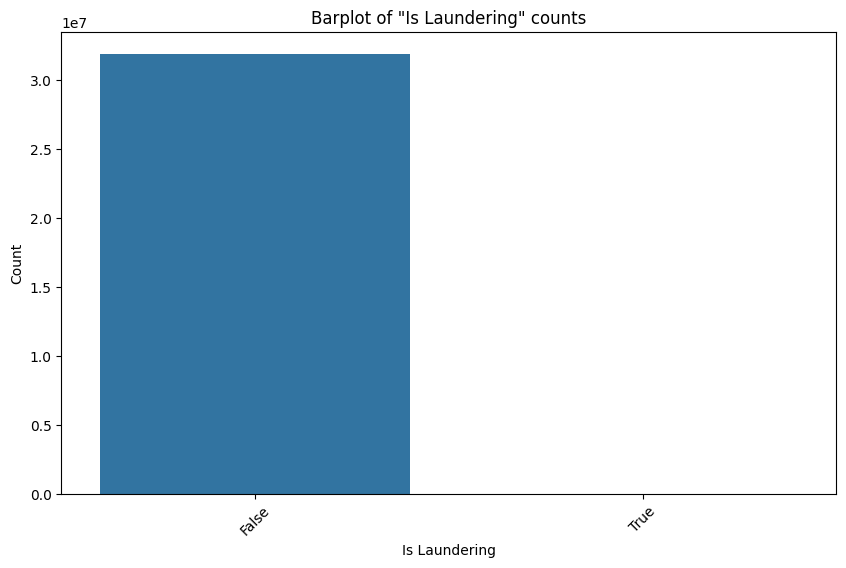

In [166]:
plot_cat_distribution(data=df, column_name="Is Laundering")

#### Анализ признака `major_options`

In [168]:
count_nulls(data=df, column_name="Is Laundering")

Число колонок с NULL: 0 (0.00%)


Пропуски есть, но их немного. Заменим их пустыми списками.

In [169]:
df = df.withColumn(
    "Is Laundering", 
    when(
        col("Is Laundering").isNull(), 
        lit([])
    ).otherwise(col("Is Laundering"))
)

count_nulls(data=df, column_name="Is Laundering")

AnalysisException: [DATATYPE_MISMATCH.DATA_DIFF_TYPES] Cannot resolve "CASE WHEN (Is Laundering IS NULL) THEN array() ELSE Is Laundering END" due to data type mismatch: Input to `casewhen` should all be the same type, but it's ["ARRAY<VOID>", "BOOLEAN"].;
'Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, CASE WHEN isnull(Is Laundering#3187) THEN array() ELSE Is Laundering#3187 END AS Is Laundering#3301]
+- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, Is Laundering#3187]
   +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, is_any_cert#3080, is_any_cert#3080 AS Is Laundering#3187]
      +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, coalesce(is_any_cert#2983, cast(false as boolean)) AS is_any_cert#3080]
         +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, is_any_cert#2983]
            +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, Is Laundering#1322, Is Laundering#1322 AS is_any_cert#2983]
               +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, CASE WHEN (cast(Amount Paid#1319 as double) > 1000000.0) THEN 1000000.0 ELSE cast(Amount Paid#1319 as double) END AS Amount Paid#2875, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                  +- Project [coalesce(Timestamp#2537, cast(Unknown as timestamp)) AS Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                     +- Project [coalesce(Timestamp#2457, cast(Unknown as timestamp)) AS Timestamp#2537, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                        +- Project [to_timestamp(Timestamp#2448, Some(yyyy/MM/dd HH:mm), TimestampType, Some(Europe/Moscow), false) AS Timestamp#2457, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                           +- Project [CASE WHEN ((Timestamp#2404 = cast( as timestamp)) OR (Timestamp#2404 = cast(NULL as timestamp))) THEN cast(null as timestamp) ELSE Timestamp#2404 END AS Timestamp#2448, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                              +- Project [to_timestamp(Timestamp#2395, Some(yyyy/MM/dd HH:mm), TimestampType, Some(Europe/Moscow), false) AS Timestamp#2404, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                 +- Project [CASE WHEN ((Timestamp#2351 = cast( as timestamp)) OR (Timestamp#2351 = cast(NULL as timestamp))) THEN cast(null as timestamp) ELSE Timestamp#2351 END AS Timestamp#2395, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                    +- Project [to_timestamp(Timestamp#2342, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Europe/Moscow), false) AS Timestamp#2351, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                       +- Project [CASE WHEN ((Timestamp#2298 = cast( as timestamp)) OR (Timestamp#2298 = cast(NULL as timestamp))) THEN cast(null as timestamp) ELSE Timestamp#2298 END AS Timestamp#2342, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                          +- Project [to_timestamp(Timestamp#2289, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Europe/Moscow), false) AS Timestamp#2298, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                             +- Project [CASE WHEN ((Timestamp#2236 = cast( as timestamp)) OR (Timestamp#2236 = cast(NULL as timestamp))) THEN cast(null as timestamp) ELSE Timestamp#2236 END AS Timestamp#2289, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                                +- Project [coalesce(Timestamp#1315, cast(Unknown as timestamp)) AS Timestamp#2236, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                                   +- Project [Timestamp#1315, From Bank#1316, To Bank#1317, CASE WHEN (cast(Amount Received#1318 as double) > 1000000.0) THEN 1000000.0 ELSE cast(Amount Received#1318 as double) END AS Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                                      +- SubqueryAlias spark_catalog.Khripunov_database.sobd_lab1_table2
                                                         +- RelationV2[Timestamp#1315, From Bank#1316, To Bank#1317, Amount Received#1318, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322] spark_catalog.Khripunov_database.sobd_lab1_table2 spark_catalog.Khripunov_database.sobd_lab1_table2


Данный признак представляет собой **массив признаков**. Обработаем его следующим образом. Определим пятёрку самых часто встречающихся элементов списка для всех объектов из датасета и введем пять **бинарных** признаков, показывающих присутствие элемента в списке конкретного объекта.

In [170]:
def get_popular_options(data: DataFrame, 
                        column: str, 
                        top_n: int = 5) -> DataFrame:
    """
    Получение DataFrame всех элементов массива опций, подсчет их количества, 
    сортировка по убыванию и вывод нескольких самых популярных элементов.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца с массивом.
        top_n (int): Количество самых популярных элементов для вывода.

    Returns:
        DataFrame: DataFrame с самыми популярными элементами.
    """
    # Развертывание массива в отдельные строки
    exploded_df = data.withColumn("element", explode(col(column)))

    # Подсчет количества каждого элемента
    element_counts = (
        exploded_df
        .groupBy("element")
        .agg(count("element").alias("count"))
    )

    # Сортировка элементов по убыванию
    sorted_elements = element_counts.orderBy(desc("count"))

    # Вывод нескольких самых популярных элементов
    top_elements = sorted_elements.limit(top_n)

    return top_elements

Получим датафрейм из пяти самых популярных опций.

In [171]:
popular_options = get_popular_options(data=df, column="Is Laundering")
popular_options.show()

AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "explode(Is Laundering)" due to data type mismatch: Parameter 1 requires the ("ARRAY" or "MAP") type, however "Is Laundering" has the type "BOOLEAN".;
'Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, Is Laundering#3187, explode(Is Laundering#3187) AS element#3302]
+- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, Is Laundering#3187]
   +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, is_any_cert#3080, is_any_cert#3080 AS Is Laundering#3187]
      +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, coalesce(is_any_cert#2983, cast(false as boolean)) AS is_any_cert#3080]
         +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, is_any_cert#2983]
            +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#2875, Payment Currency#1320, Payment Format#1321, Is Laundering#1322, Is Laundering#1322 AS is_any_cert#2983]
               +- Project [Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, CASE WHEN (cast(Amount Paid#1319 as double) > 1000000.0) THEN 1000000.0 ELSE cast(Amount Paid#1319 as double) END AS Amount Paid#2875, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                  +- Project [coalesce(Timestamp#2537, cast(Unknown as timestamp)) AS Timestamp#2598, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                     +- Project [coalesce(Timestamp#2457, cast(Unknown as timestamp)) AS Timestamp#2537, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                        +- Project [to_timestamp(Timestamp#2448, Some(yyyy/MM/dd HH:mm), TimestampType, Some(Europe/Moscow), false) AS Timestamp#2457, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                           +- Project [CASE WHEN ((Timestamp#2404 = cast( as timestamp)) OR (Timestamp#2404 = cast(NULL as timestamp))) THEN cast(null as timestamp) ELSE Timestamp#2404 END AS Timestamp#2448, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                              +- Project [to_timestamp(Timestamp#2395, Some(yyyy/MM/dd HH:mm), TimestampType, Some(Europe/Moscow), false) AS Timestamp#2404, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                 +- Project [CASE WHEN ((Timestamp#2351 = cast( as timestamp)) OR (Timestamp#2351 = cast(NULL as timestamp))) THEN cast(null as timestamp) ELSE Timestamp#2351 END AS Timestamp#2395, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                    +- Project [to_timestamp(Timestamp#2342, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Europe/Moscow), false) AS Timestamp#2351, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                       +- Project [CASE WHEN ((Timestamp#2298 = cast( as timestamp)) OR (Timestamp#2298 = cast(NULL as timestamp))) THEN cast(null as timestamp) ELSE Timestamp#2298 END AS Timestamp#2342, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                          +- Project [to_timestamp(Timestamp#2289, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Europe/Moscow), false) AS Timestamp#2298, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                             +- Project [CASE WHEN ((Timestamp#2236 = cast( as timestamp)) OR (Timestamp#2236 = cast(NULL as timestamp))) THEN cast(null as timestamp) ELSE Timestamp#2236 END AS Timestamp#2289, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                                +- Project [coalesce(Timestamp#1315, cast(Unknown as timestamp)) AS Timestamp#2236, From Bank#1316, To Bank#1317, Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                                   +- Project [Timestamp#1315, From Bank#1316, To Bank#1317, CASE WHEN (cast(Amount Received#1318 as double) > 1000000.0) THEN 1000000.0 ELSE cast(Amount Received#1318 as double) END AS Amount Received#2086, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322]
                                                      +- SubqueryAlias spark_catalog.Khripunov_database.sobd_lab1_table2
                                                         +- RelationV2[Timestamp#1315, From Bank#1316, To Bank#1317, Amount Received#1318, Amount Paid#1319, Payment Currency#1320, Payment Format#1321, Is Laundering#1322] spark_catalog.Khripunov_database.sobd_lab1_table2 spark_catalog.Khripunov_database.sobd_lab1_table2


In [ ]:
def add_options_columns(data: DataFrame,
                        column: str,
                        popular_options: DataFrame) -> DataFrame:
    """
    Добавление новых булевых колонок в DataFrame, указывающих, 
    содержится ли определённый элемент в каждой строке.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца с массивом.
        popular_elements (DataFrame): DataFrame с популярными элементами.

    Returns:
        DataFrame: DataFrame с новыми булевыми колонками.
    """
    # Добавление булевых колонок для каждой популярной категории
    categories_df = popular_options.select(col("element").alias("category"))
    result = data.crossJoin(categories_df.hint("broadcast"))
    result = result.withColumn("contains", 
                               array_contains(col(column), col("category")))
    result = result.groupBy(data.columns).pivot("category").agg(first("contains"))
    
    for col_name in result.columns:
        if col_name not in data.columns:
            result = result.withColumnRenamed(col_name, f"contains_{col_name}")
    
    return result

Выполним вышеописанное преобразование над датасетом, а признак-массив удалим.

In [ ]:
df = add_options_columns(data=df, column="major_options", 
                         popular_options=popular_options)
df = df.drop("major_options").cache()
df.show()

#### Анализ столбца `maximum_seating`

Данный признак является **количественным**.

In [ ]:
count_nulls(data=df, column_name="maximum_seating")

In [ ]:
(
    df
    .filter(col("maximum_seating").isNotNull())
    .groupBy("maximum_seating")
    .count()
    .show()
)

Оставим только те автомобили, число мест в которых менее 20. Их преобладающее количество.

In [ ]:
df = df.filter(col("maximum_seating") < 20)
mean_maximum_seating = int(
    df.select(mean(col("maximum_seating"))).collect()[0][0]
)
mean_maximum_seating

Заменим пропуски средним значением.

In [ ]:
df = df.fillna({"maximum_seating": mean_maximum_seating})

In [ ]:
plot_cat_distribution(data=df, column_name="maximum_seating")

In [ ]:
df.show()

#### Анализ признака `price`

Признак **количественный**. Все преобразования аналогичны вышерассмотренным.

In [ ]:
count_nulls(data=df, column_name="price")

In [ ]:
plot_boxplots(data=df, columns=["price"])

In [ ]:
df.filter(col("price") > 60000).count()

In [ ]:
df = df.filter(col("price") <= 60000)
plot_quant_distribution(data=df, column="price")

In [ ]:
df.show()

#### Анализ столбца `wheel_system`

Признак **категориальный**.

In [ ]:
count_nulls(data=df, column_name="wheel_system")

In [ ]:
(
    df
    .filter(col("wheel_system").isNotNull())
    .groupBy("wheel_system")
    .count()
    .show()
)

Заменим пропуски модой.

In [ ]:
wheel_system_mode = (
    df
    .filter(col("wheel_system").isNotNull())
    .groupBy("wheel_system")
    .count()
    .orderBy("count", ascending=False)
    .first()[0]
)
wheel_system_mode

In [ ]:
df = df.fillna({"wheel_system": wheel_system_mode})

In [ ]:
plot_cat_distribution(data=df, column_name="wheel_system")

In [ ]:
df.show()

#### Анализ столбца `mileage`

Признак **количественный**.

In [ ]:
count_nulls(data=df, column_name="mileage")

In [ ]:
df = df.filter(col("mileage").isNotNull())
count_nulls(data=df, column_name="mileage")

In [ ]:
plot_boxplots(data=df, columns=["mileage"])

In [ ]:
plot_quant_distribution(data=df, column="mileage")

In [ ]:
df = df.filter(col("mileage") <= 200000.0)
plot_quant_distribution(data=df, column="mileage")

In [ ]:
df.show()

#### Анализ признака `year`

Признак **количественный**.

Преобразуем год выпуска в количество лет с года выпуска до 2024 года.

In [ ]:
df = df.withColumn("age", lit(2024) - col("year")).drop("year")
df.show()

#### Расчет корреляции между количественными признаками

In [172]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

In [ ]:
print(df.columns)


['Timestamp', 'From Bank', 'To Bank', 'Amount Received', 'Amount Paid', 'Payment Currency', 'Payment Format', 'is_any_cert']


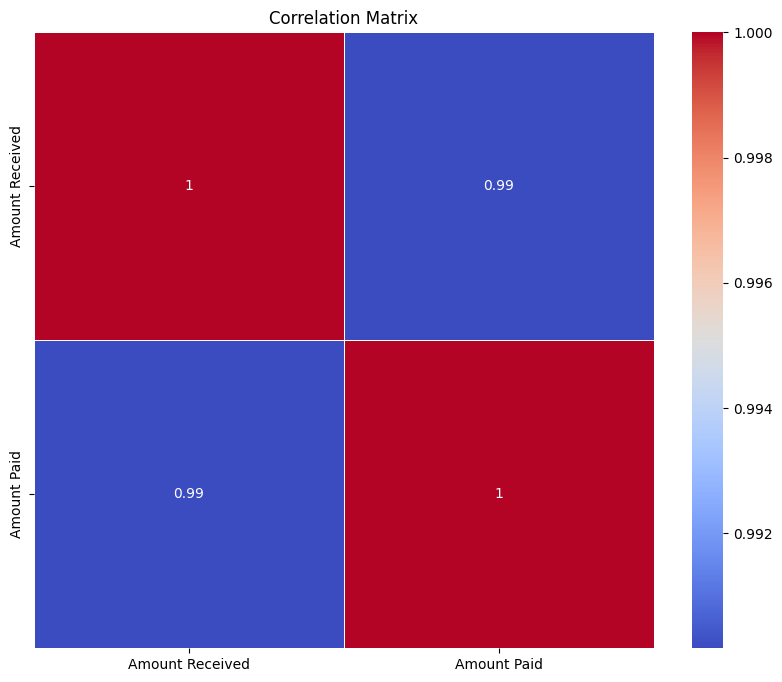

In [173]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "Amount Received", "Amount Paid"
    ]
)

Корреляционная матрица демонстрирует наличие корреляции между некоторыми количественными признаками.

In [174]:
df.show()

+---------+---------+-------+------------------+------------------+----------------+--------------+-------------+
|Timestamp|From Bank|To Bank|   Amount Received|       Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+-------+------------------+------------------+----------------+--------------+-------------+
|     NULL|  0037220|0143318|       67597.03125|       67597.03125|            Yuan|   Credit Card|        false|
|     NULL|  0037220|0143318|         1000000.0|         1000000.0|            Yuan|           ACH|        false|
|     NULL|  0018184|0018184| 64.12000274658203| 64.12000274658203|            Yuan|  Reinvestment|        false|
|     NULL|  0117909|0040526|         1000000.0|         1000000.0|            Yuan|        Cheque|        false|
|     NULL|  0117909|0040526|     183521.265625|     183521.265625|            Yuan|   Credit Card|        false|
|     NULL|  0117909|0040526|         1000000.0|         1000000.0|            Yuan|    

Посмотрим, сколько объектов осталось после преобразований датасета.

In [175]:
df.count()

31898238

In [176]:
df.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Amount Received: double (nullable = true)
 |-- Amount Paid: double (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: boolean (nullable = false)



Сохраняет очищенную и обработанную таблицу на диск.

In [ ]:
# Сохранение DataFrame в виде таблицы
df.writeTo("sobd_lab1_processed_table").using("iceberg").create()

In [ ]:
for table in spark.catalog.listTables():
    print(table.name)

Обратите внимание, что при необходимости созданные базу данных и таблицу можно удалить следующими командами.

In [ ]:
# spark.sql("DROP TABLE spark_catalog.ivanov_database.sobd_lab1_processed_table")
# spark.sql("DROP DATABASE spark_catalog.ivanov_database")

Останавливаем `Spark`-сессию.

In [ ]:
spark.stop()